Generate initial unnormalised high-res GDSE sim:
- Generate high resolution white noise image
- fft to the uv-domain
- scale according to input spatial power law

Create simulation subsets and products required to normalise the high-res. sim. relative to the low resolution GSM model.
Constructing two additional products - the low-res centre of the high-res. uv-plane (containing only the scales sampled by the GSM) and a high-res uv-plane with all of the high-res information (the information not present in the GSM) zeroed.
ffting these products to the uv-domain should produce images with consistent standard deviations (confirming this will ensures that the GSM scaling factor can be correctly applied to the high-res uv-plane:
- Define a separate copy of the low-res centre of the high-res. uv-plane (containing only the scales sampled by the GSM)
- Define a separate copy of the high-res uv-plane with all of the high-res information (the information not present in the GSM) zeroed.

Derive normalisation constant:
- fft copy of the low-res centre of the high-res. uv-plane to the image. Call this GDSE_lr
- fft high-res uv-plane with all of the high-res information (the information not present in the GSM) zeroed to the image. Call this GDSE_hr_low_pass_filtered.
- GDSE_lr is at the same resolution as the GSM so can be normalised directly. GDSE_hr_low_pass_filtered is a Fourier interpolated version of GDSE_lr onto a higher resolution grid but with no aditional high-res power, it should therefore have the same standard deviation as GDSE_lr and the same normalisation factor should therefore be applicable. Confirm that this is the case!


Import libs

In [1]:
import numpy
import numpy as np
from numpy import * 
import pylab
import pylab as P
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from scipy import misc
from scipy import ndimage
import numpy as np

Define constants: GSM normalisation, FoV, resolution etc.

In [2]:

# Tb_experimental_std_K = 62.0
Tb_experimental_std_K = 62.0 #~70th percentile std according to GSM_map_std_at_-30_dec_v1d0.ipynb
# FoV_deg = 12.34 #12.0 degrees is the required FoV for the foregrounds (matching the 12.0407656283 deg. of the 128*128 pix EoR sim)
FoV_deg = 12.134 #12.0 degrees is the required FoV for the foregrounds (matching the 12.0407656283 deg. of the 128*128 pix EoR sim)
FoV_rad = FoV_deg*(np.pi/180.)
###
#low-res. image constants
###
# lres_deg = 1./3 #1/3 deg Haslam map
lres_deg = (56./60) #56 arcmin resolution Remazeilles Haslam map
lres_rad = lres_deg*(np.pi/180.)
N_lr = int(FoV_deg/lres_deg) #FoV_deg/start_res = 36
print N_lr
d_Omega_lr = lres_rad**2.
duv_lr = 1./d_Omega_lr

###
#high-res. image constants
###
N_hr = 127
hres_deg = FoV_deg/N_hr
hres_rad = hres_deg*(np.pi/180.)
print N_hr
print hres_deg #EoR sim. is 0.09406848147109376 deg.
d_Omega_hr = hres_rad**2.
duv_hr = 1./d_Omega_hr

###
#Spatial power spectrum
###
spatial_power_spectrum_index = -3.0
spatial_amplitude_spectrum_index = spatial_power_spectrum_index/2.


13
127
0.0955433070866


Generate a GRN realisation map and fft to the uv-domain

In [3]:
np.random.seed(1274+3142)
wn_im_hr=np.random.normal(0,10,N_hr**2).reshape(N_hr,N_hr)
axes_tuple=(0,1)
fft_wn_im_hr=numpy.fft.ifftshift(wn_im_hr, axes=axes_tuple)
fft_wn_im_hr=numpy.fft.fftn(fft_wn_im_hr, axes=axes_tuple) #FFT (python pre-normalises correctly! -- see parsevals theorem for discrete fourier transform.)
fft_wn_im_hr=numpy.fft.fftshift(fft_wn_im_hr, axes=axes_tuple)
fft_wn_im_hr = d_Omega_hr*fft_wn_im_hr #Apply physical normalisation for FFT as per Beardsley doc.

Generate scaling field to impart desired spatial power spectrum

In [4]:
u_axis_hr = (arange(N_hr)-(N_hr/2)) * (1./FoV_rad) #uv-plane in inverse degrees
v_axis_hr = (arange(N_hr)-(N_hr/2)) * (1./FoV_rad) #uv-plane in inverse degrees
u_hr,v_hr = np.meshgrid(u_axis_hr,v_axis_hr)
u_vec_hr = u_hr.flatten()
v_vec_hr = v_hr.flatten()
uv_vec_hr = (u_vec_hr**2.+v_vec_hr**2.)**0.5

uv_hr = (u_hr**2.+v_hr**2.)**0.5
uv_spatial_power_law_scaling_hr = uv_hr**spatial_power_spectrum_index #i.e. uv_hr**-3.0
uv_amplitude_scaling_hr = uv_spatial_power_law_scaling_hr**0.5
uv_amplitude_scaling_hr[np.where(np.isinf(uv_amplitude_scaling_hr))] = 0.0 #Set the mean to zero
uv_amplitude_scaling_hr = uv_amplitude_scaling_hr/uv_amplitude_scaling_hr.mean() #Unitary tranform


/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in power


Scale fft'd white noise image in the uv-plane to impart GDSE spatial power spectrum

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


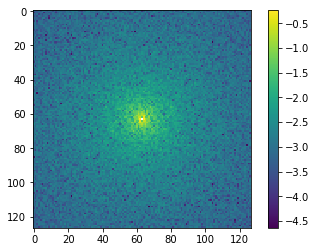

In [5]:
scaled_fft_wn_im_hr = fft_wn_im_hr*uv_amplitude_scaling_hr

P.imshow(np.log10(abs(scaled_fft_wn_im_hr)))
P.colorbar()
P.show()

Note: scaled_fft_wn_im_hr is the uv-plane representation of my unnormalised GDSE simulation.
Next step: perform normalisation.
To do this, create simulation subsets and products required to normalise the high-res. sim. relative to the low resolution GSM model. Constructing two additional products - the low-res centre of the high-res. uv-plane (containing only the scales sampled by the GSM) and a high-res uv-plane with all of the high-res information (the information not present in the GSM) zeroed. ffting these products to the uv-domain should produce images with consistent standard deviations (confirming this will ensures that the GSM scaling factor can be correctly applied to the high-res uv-plane.

Define a separate copy of the low-res centre of the high-res. uv-plane (containing only the scales sampled by the GSM)

57 127 13


/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


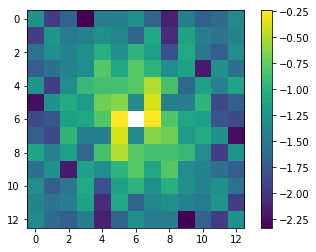

In [6]:
#The width of the outer part of the high-res. uv-plane containing information not sampled by the GSM
padding_width = (N_hr-N_lr)/2
print padding_width, N_hr, N_lr

# Low-res. uv-plane to be fft'd to the image for direct comparison to the GSM standard deviation
scaled_fft_wn_im_lr = scaled_fft_wn_im_hr[padding_width:-padding_width,padding_width:-padding_width].copy()

P.imshow(np.log10(abs(scaled_fft_wn_im_lr)))
P.colorbar()
P.show()


Define a separate copy of the high-res uv-plane with all of the high-res information (the information not present in the GSM) zeroed.

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


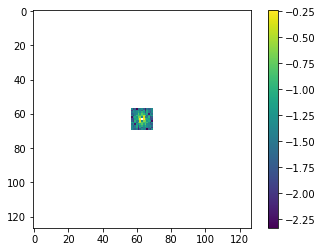

In [7]:
zero_padded_scaled_fft_wn_im_lr = np.zeros([N_hr,N_hr])+0.0j
zero_padded_scaled_fft_wn_im_lr[padding_width:-padding_width,padding_width:-padding_width] = scaled_fft_wn_im_lr

P.imshow(np.log10(abs(zero_padded_scaled_fft_wn_im_lr)))
P.colorbar()
P.show()


Derive normalisation constant.
fft copy of the low-res centre of the high-res. uv-plane to the image. Call this GDSE_lr
fft high-res uv-plane with all of the high-res information (the information not present in the GSM) zeroed to the image. Call this GDSE_hr_low_pass_filtered.

scaled_wn_im_lr.shape, scaled_wn_im_lr.std(): (13, 13) 32.8187697105
zero_padded_scaled_wn_im_lr.shape, zero_padded_scaled_wn_im_lr.std(): (127, 127) 32.8151635496


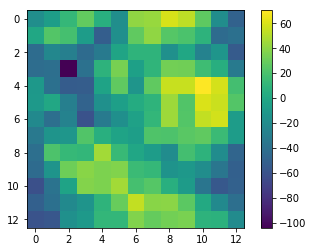

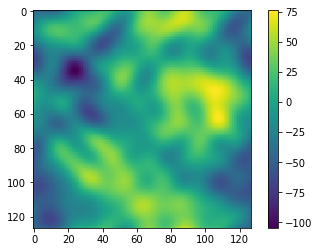

In [8]:
###
# fft these next!
###
# scaled_fft_wn_im_lr
# zero_padded_scaled_fft_wn_im_lr

scaled_wn_im_lr=numpy.fft.ifftshift(scaled_fft_wn_im_lr, axes=axes_tuple)
scaled_wn_im_lr=numpy.fft.ifftn(scaled_wn_im_lr, axes=axes_tuple) #FFT (python pre-normalises correctly! -- see parsevals theorem for discrete fourier transform.)
scaled_wn_im_lr=numpy.fft.fftshift(scaled_wn_im_lr, axes=axes_tuple)
scaled_wn_im_lr=duv_lr*scaled_wn_im_lr

zero_padded_scaled_wn_im_lr=numpy.fft.ifftshift(zero_padded_scaled_fft_wn_im_lr, axes=axes_tuple)
zero_padded_scaled_wn_im_lr=numpy.fft.ifftn(zero_padded_scaled_wn_im_lr, axes=axes_tuple) #FFT (python pre-normalises correctly! -- see parsevals theorem for discrete fourier transform.)
zero_padded_scaled_wn_im_lr=numpy.fft.fftshift(zero_padded_scaled_wn_im_lr, axes=axes_tuple)
zero_padded_scaled_wn_im_lr=duv_hr*zero_padded_scaled_wn_im_lr

print 'scaled_wn_im_lr.shape, scaled_wn_im_lr.std():', scaled_wn_im_lr.shape, scaled_wn_im_lr.std()
print 'zero_padded_scaled_wn_im_lr.shape, zero_padded_scaled_wn_im_lr.std():', zero_padded_scaled_wn_im_lr.shape, zero_padded_scaled_wn_im_lr.std()

P.figure()
P.imshow(scaled_wn_im_lr.real)
P.colorbar()

P.figure()
P.imshow(zero_padded_scaled_wn_im_lr.real)
P.colorbar()
P.show()


GDSE_lr is at the same resolution as the GSM so can be normalised directly. GDSE_hr_low_pass_filtered is a Fourier interpolated version of GDSE_lr onto a higher resolution grid but with no aditional high-res power, it should therefore have the same standard deviation as GDSE_lr and the same normalisation factor should therefore be applicable. Confirm that this is the case!

95.4273830088
normalised_scaled_wn_im_lr.shape, normalised_scaled_wn_im_lr.std(): (13, 13) 62.0
normalised_zero_padded_scaled_wn_im_lr.shape, normalised_zero_padded_scaled_wn_im_lr.std(): (127, 127) 61.9931873747


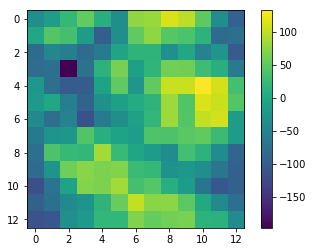

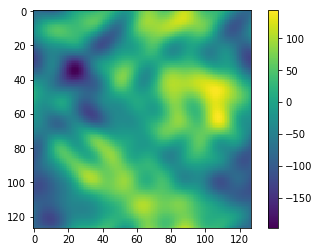

In [9]:
gsm_normalisation_factor = (Tb_experimental_std_K/scaled_wn_im_lr.std())
normalised_scaled_wn_im_lr = scaled_wn_im_lr* gsm_normalisation_factor
normalised_zero_padded_scaled_wn_im_lr = zero_padded_scaled_wn_im_lr* gsm_normalisation_factor

print duv_hr/duv_lr
print 'normalised_scaled_wn_im_lr.shape, normalised_scaled_wn_im_lr.std():', normalised_scaled_wn_im_lr.shape, normalised_scaled_wn_im_lr.std()
print 'normalised_zero_padded_scaled_wn_im_lr.shape, normalised_zero_padded_scaled_wn_im_lr.std():',normalised_zero_padded_scaled_wn_im_lr.shape, normalised_zero_padded_scaled_wn_im_lr.std()

P.figure()
P.imshow(normalised_scaled_wn_im_lr.real)
P.colorbar()

P.figure()
P.imshow(normalised_zero_padded_scaled_wn_im_lr.real)
P.colorbar()
P.show()


Apply gsm_normalisation_factor to the full high-res GDSE sim and fft to the image domain

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


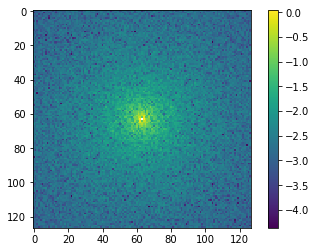

In [10]:
normalised_scaled_fft_wn_im_hr = scaled_fft_wn_im_hr*gsm_normalisation_factor

P.imshow(np.log10(abs(normalised_scaled_fft_wn_im_hr)))
P.colorbar()
P.show()



normalised_scaled_wn_im_lr.shape, normalised_scaled_wn_im_lr.std(): (13, 13) 62.0
normalised_zero_padded_scaled_wn_im_lr.shape, normalised_zero_padded_scaled_wn_im_lr.std(): (127, 127) 61.9931873747
normalised_scaled_wn_im_hr.shape, normalised_scaled_wn_im_hr.std(): (127, 127) 65.9491219485
low_res_to_high_res_std_conversion_factor 1.0636955153


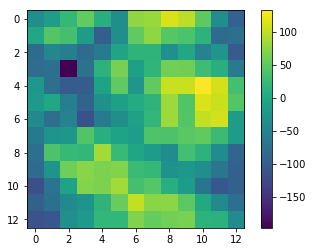

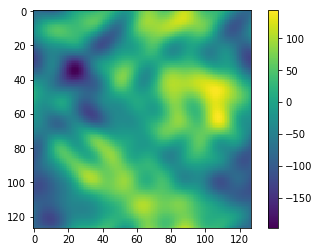

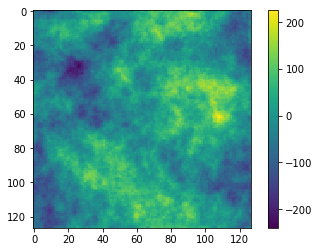

In [11]:

normalised_scaled_wn_im_hr=numpy.fft.ifftshift(normalised_scaled_fft_wn_im_hr, axes=axes_tuple)
normalised_scaled_wn_im_hr=numpy.fft.ifftn(normalised_scaled_wn_im_hr, axes=axes_tuple) #FFT (python pre-normalises correctly! -- see parsevals theorem for discrete fourier transform.)
normalised_scaled_wn_im_hr=numpy.fft.fftshift(normalised_scaled_wn_im_hr, axes=axes_tuple)
normalised_scaled_wn_im_hr=duv_hr*normalised_scaled_wn_im_hr

print 'normalised_scaled_wn_im_lr.shape, normalised_scaled_wn_im_lr.std():', normalised_scaled_wn_im_lr.shape, normalised_scaled_wn_im_lr.std()
print 'normalised_zero_padded_scaled_wn_im_lr.shape, normalised_zero_padded_scaled_wn_im_lr.std():',normalised_zero_padded_scaled_wn_im_lr.shape, normalised_zero_padded_scaled_wn_im_lr.std()
print 'normalised_scaled_wn_im_hr.shape, normalised_scaled_wn_im_hr.std():', normalised_scaled_wn_im_hr.shape, normalised_scaled_wn_im_hr.std()
low_res_to_high_res_std_conversion_factor = normalised_scaled_wn_im_hr.std()/normalised_scaled_wn_im_lr.std()
print 'low_res_to_high_res_std_conversion_factor', low_res_to_high_res_std_conversion_factor


P.figure()
P.imshow(normalised_scaled_wn_im_lr.real)
P.colorbar()

P.figure()
P.imshow(normalised_zero_padded_scaled_wn_im_lr.real)
P.colorbar()

P.figure()
P.imshow(normalised_scaled_wn_im_hr.real)
P.colorbar()
P.show()


Look at 3 deg. subset to compare to Jelic sim.

In [12]:
# normalised_scaled_wn_im_hr_3_deg_subset = normalised_scaled_wn_im_hr[0:N_hr/4,0:N_hr/4].copy()
# print 'normalised_scaled_wn_im_hr_3_deg_subset.std()', normalised_scaled_wn_im_hr_3_deg_subset.std()

# P.figure()
# P.imshow(normalised_scaled_wn_im_hr[0:N_hr/4,0:N_hr/4].real + 200.0, vmin=200.0,vmax=230.0)
# P.colorbar()

# P.figure()
# P.imshow(normalised_scaled_wn_im_hr[0:N_hr/4,0:N_hr/4].real + 200.0)
# P.colorbar()
# P.show()
